<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 4. Scaling</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# general
import numpy as np
import pandas as pd
import random as rd
import copy

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    chi2_contingency, f_oneway)

# machine learning prep
from sklearn.preprocessing import (
    MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer)
from collections import Counter
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, auc, roc_auc_score,
    precision_recall_curve, plot_precision_recall_curve, average_precision_score, precision_recall_fscore_support,
    classification_report, precision_recall_fscore_support, confusion_matrix, SCORERS)
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import (SVC, LinearSVC) # remove SVC later if not used
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, IsolationForest)
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# saving
import os

# multiprocessing
import concurrent.futures
import time

In [2]:
# settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [3]:
# pd.set_options('precision', 3)
# pd.set_options('min_rows', 6)
# pd.set_options('max_rows', 10)
# pd.reset_option('max_rows')
# pd.set_option('max_colwidth', 10)
# pd.set_option("chop_threshold", 0.5)
# pd.reset_option("chop_threshold")
# pd.set_option("colheader_justify", "left")
# pd.reset_option("colheader_justify")
# plt.rc('figure',figsize=(8,4))
# plt.style.use('seaborn-whitegrid')
# from IPython.display import display, Math, Latex
# pio.renderers.default='plotly_mimetype'

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Data Loading</h2></a>

In [4]:
start_normal = time.perf_counter()

In [5]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


<a id='4.3'>
    <h2 style='font-size:180%;'>
        Train Test Split</h2></a>

In [6]:
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Functions to Use</h2>

In [7]:
def perf_metrics(y_test, yhat):
    dic = {}
    dic['accuracy'] = round(accuracy_score(y_test, yhat)*100, 2)
    dic['precision'] = round(precision_score(y_test, yhat)*100, 2)
    dic['recall'] = round(recall_score(y_test, yhat)*100, 2)
    dic['f1'] = round(f1_score(y_test, yhat)*100, 2)
    dic['f2'] = round(fbeta_score(y_test, yhat, beta=2)*100, 2)
    return dic

In [8]:
def results_full(models, scaler, set_applied='validation'):
    
    """
    Function
    ----------
    Returns a dictionary of tuples of `model name` and a 
    dictionary of `metrics` for each model on the user-defined set
    
    Parameters
    ----------
    set_applied : str
        'validation' by default. The other option is 'test' or any other texts work as 'test'
    models : list of tuples
        List of tuples of all models of interest
    scaler : instantiation
        Instantiation of scaler of interest
        
    Returns
    -------
    results_dic : dict
        Dictionary of tuples of `model name` and a dictionary of `metrics` for each model
    """
    
    results, names = [], []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler),('m', model)])
        if set_applied=='validation':  # apply on validation sets
            cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)        
            results = cross_validate(
                pipeline, x_train, y_train, cv=cv, 
                scoring=scoring, return_train_score=True, n_jobs=-1)
        else:  # apply on test sets
            pipeline.fit(x_train, y_train)
            yhat = pipeline.predict(x_test)
            results = perf_metrics(y_test, yhat)            
        names.append(name)
        results.append(results)            
    results_dic = dict(zip(names, results))
    return results_dic

In [9]:
def results_validation(models, scaler):
    
    """
    Function
    ----------
    Returns a dictionary of tuples of `model name` and a 
    dictionary of `metrics` for each model on the validation set
    (stratified 5-fold cross validation)
    
    Parameters
    ----------
    models : list of tuples
        List of tuples of all models of interest
    scaler : instantiation
        Instantiation of scaler of interest
        
    Returns
    -------
    results_dic : dict
        Dictionary of tuples of `model name` and a dictionary of `metrics` for each model
    """
    
    results = []
    names = []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler),('m', model)])
        # apply on cross validation sets generated by Stratified K Fold
        cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)        
        cv_results = cross_validate(
            pipeline, x_train, y_train, cv=cv, 
            scoring=scoring, return_train_score=True, n_jobs=-1)
        # create a list of model names
        names.append(name)
        # create a list of dictionaries of all metrics for each model
        results.append(cv_results)
    results_dic = dict(zip(names, results))
    return results_dic

In [10]:
def results_test(models, scaler):
    
    """
    Function
    ----------
    Returns a dictionary of tuples of `model name` and a 
    dictionary of `metrics` for each model on the test set
    
    Parameters
    ----------
    models : list of tuples
        List of tuples of all models of interest
    scaler : instantiation
        Instantiation of scaler of interest
        
    Returns
    -------
    results_dic : dict
        Dictionary of tuples of `model name` and a dictionary of `metrics` for each model
    """
    
    results = []
    names = []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    for name, model in models:
        pipeline = Pipeline([('scaler', scaler),('m', model)])
        
        pipeline.fit(x_train, y_train)
        yhat = pipeline.predict(x_test)
        test_metrics = perf_metrics(y_test, yhat)
        # create a list of model names
        names.append(name)
        # create a list of dictionaries of all metrics for each model
        results.append(test_metrics)
    results_dic = dict(zip(names, results))
    return results_dic

In [11]:
def results_summary_df(results_dic):
    
    """
    Function
    ----------
    Returns a dataframe of mean and std of all metrics for each model
    
    Parameters
    ----------
    results_dic : dict
        Dictionary of all models and their metrics in another dictionary
        
    Returns
    -------
    results_summary_df : DataFrame
        DataFrame of mean and std of all metrics (cols) for each model (index)
    """
    
    names, results = [], []
    for k,v in results_dic.items():
        names.append(k)
        results.append(v)
    results_summary_df = pd.DataFrame()
    for i in np.arange(len(names)):
        results_metric, results_mean, results_std = [], [], []
        for k,v in results[i].items():
            results_metric.append(k)
            results_mean.append(np.round(np.mean(v),3))
            results_std.append(np.round(np.std(v),3))
        df = pd.DataFrame(
                list(zip(results_metric, results_mean, results_std, [names[i] for ct in np.arange(len(results[0]))])), 
                columns=['metric', 'mean', 'std', 'mod'])
        df = df.set_index(['mod','metric']).stack().unstack([1,2])
        results_summary_df = pd.concat([results_summary_df, df])
    return(results_summary_df)

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Benchmark</h2>

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Functions for Baseline Models with <code>MinMaxScaler()</code></h2></a>

<a id='5.3.1'>
    <h2 style='font-size:150%;'>
        Comment on <code>MinMaxScaler()</code></h2></a>

The `MinMaxScaler()` transforms each feature individually by bounding the minimum and maximum values of each feature to a given range, usually `0` and `1`. If negative values exist, the scaler will bound the values to `-1` and `1`. This Scaler responds well if **the standard deviation is small** and when a **distribution is not Gaussian**. As this scaler is **sensitive to outliers**, it is important to treat outliers beforehand. We will see the effects of Outlier Treatment in a later section.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)<br>
[Standardize or Normalize Examples in Python, *Medium*](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

<a id='4.2'>
    <h2 style='font-size:240%;'>
        Baseline Models</h2></a>

In [12]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)]
models = []
models.append(('LR', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=5))) # `max_iter` from 1000 to 10000 due to convergence issue
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('CART', DecisionTreeClassifier(random_state=5)))
models.append(('RF', RandomForestClassifier(random_state=5)))
models.append(('NB', GaussianNB()))
models.append(('GB', GradientBoostingClassifier(random_state=5)))
models.append(('MLP', MLPClassifier(max_iter=1000, random_state=5)))

# create an instance of scaler to use
scaler = MinMaxScaler()

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Validation Set</h2></a>

In [13]:
# def results_validation(models, scaler):
    
#     """
#     Function
#     ----------
#     Returns a dictionary of tuples of `model name` and a 
#     dictionary of `metrics` for each model on the validation set
#     (stratified 5-fold cross validation)
    
#     Parameters
#     ----------
#     models : list of tuples
#         List of tuples of all models of interest
#     scaler : instantiation
#         Instantiation of scaler of interest
        
#     Returns
#     -------
#     results_dic : dict
#         Dictionary of tuples of `model name` and a dictionary of `metrics` for each model
#     """
    
#     results = []
#     names = []
#     scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
#     for name, model in models:
#         pipeline = Pipeline([('scaler', scaler),('m', model)])
#         # apply on cross validation sets generated by Stratified K Fold
#         cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)        
#         cv_results = cross_validate(
#             pipeline, x_train, y_train, cv=cv, 
#             scoring=scoring, return_train_score=True, n_jobs=-1)
#         # create a list of model names
#         names.append(name)
#         # create a list of dictionaries of all metrics for each model
#         results.append(cv_results)
#     results_dic = dict(zip(names, results))
#     yield results_dic

In [14]:
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     results_dic = executor.map(results_validation, [(models, scaler)])

In [15]:
# results_dic

In [16]:
# results_dic.__next__()

In [17]:
results_dic = results_validation(models, scaler)

In [18]:
results_baseline = results_summary_df(results_dic)

In [19]:
results_baseline

metric fit_time       score_time      test_accuracy      train_accuracy       \
           mean   std       mean  std          mean  std           mean  std   
mod                                                                            
LR         0.28  0.03       0.01 0.00          0.86 0.01           0.86 0.00   
LDA        0.17  0.05       0.02 0.01          0.91 0.01           0.91 0.00   
KNN        0.01  0.00       0.71 0.11          0.88 0.01           1.00 0.00   
CART       0.18  0.04       0.01 0.00          0.94 0.01           1.00 0.00   
RF         2.61  0.61       0.11 0.03          0.96 0.01           1.00 0.00   
NB         0.02  0.00       0.02 0.00          0.89 0.01           0.90 0.00   
GB         6.34  1.43       0.03 0.01          0.96 0.01           0.97 0.00   
MLP       62.90 15.99       0.02 0.01          0.94 0.01           0.97 0.01   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.54 0.02            0.54 0.00        0.86 0.03         0.86   
LDA              0.78 0.02            0.78 0.00        0.63 0.06         0.63   
KNN              0.63 0.03            1.00 0.00        0.56 0.05         1.00   
CART             0.80 0.03            1.00 0.00        0.80 0.04         1.00   
RF               0.92 0.02            1.00 0.00        0.83 0.04         1.00   
NB               0.71 0.05            0.71 0.01        0.58 0.05         0.59   
GB               0.93 0.02            0.95 0.00        0.84 0.04         0.89   
MLP              0.85 0.04            0.92 0.02        0.79 0.03         0.87   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.66 0.02     0.66 0.00         0.93 0.01          0.93 0.00  
LDA    0.01    0.69 0.04     0.70 0.01         0.93 0.01          0.93 0.00  
KNN    0.00    0.59 0.03     1.00 0.00         0.75 0.02          1.00 0.00  
CART   0.00    0.80 0.02     1.00 0.00         0.88 0.02          1.00 0.00  
RF     0.00    0.87 0.02     1.00 0.00         0.99 0.00          1.00 0.00  
NB     0.02    0.64 0.04     0.65 0.01         0.87 0.02          0.88 0.00  
GB     0.00    0.88 0.02     0.92 0.00         0.99 0.00          0.99 0.00  
MLP    0.03    0.82 0.02     0.90 0.02         0.97 0.01          0.99 0.00

We can see some strong signs of overfitting for `KNN`, `CART`, and `RF`.</br>
Some promising signs for hyperparameter tuning for `GB` and `MLP`.

In [20]:
results_baseline[['test_recall', 'train_recall']]

metric test_recall      train_recall     
              mean  std         mean  std
mod                                      
LR            0.86 0.03         0.86 0.00
LDA           0.63 0.06         0.63 0.01
KNN           0.56 0.05         1.00 0.00
CART          0.80 0.04         1.00 0.00
RF            0.83 0.04         1.00 0.00
NB            0.58 0.05         0.59 0.02
GB            0.84 0.04         0.89 0.00
MLP           0.79 0.03         0.87 0.03

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Test Set</h2></a>

In [21]:
scaler = MinMaxScaler()
results_dic_test = results_test(models, scaler)

In [22]:
results_baseline_test = results_summary_df(results_dic_test)

In [23]:
results_baseline_test

metric accuracy      precision      recall         f1         f2     
           mean  std      mean  std   mean  std  mean  std  mean  std
mod                                                                  
LR        85.04 0.00     51.99 0.00  88.62 0.00 65.53 0.00 77.67 0.00
LDA       91.86 0.00     79.20 0.00  66.77 0.00 72.45 0.00 68.93 0.00
KNN       87.41 0.00     62.32 0.00  54.46 0.00 58.13 0.00 55.87 0.00
CART      93.53 0.00     77.87 0.00  83.38 0.00 80.53 0.00 82.22 0.00
RF        97.09 0.00     93.46 0.00  88.00 0.00 90.65 0.00 89.04 0.00
NB        89.34 0.00     71.04 0.00  56.62 0.00 63.01 0.00 59.01 0.00
GB        97.24 0.00     92.97 0.00  89.54 0.00 91.22 0.00 90.20 0.00
MLP       95.11 0.00     85.99 0.00  83.08 0.00 84.51 0.00 83.64 0.00

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Compare Algorithm</h2></a>

In [24]:
names, results = [], []
for k,v in results_dic.items():
    names.append(k)
    results.append(v)

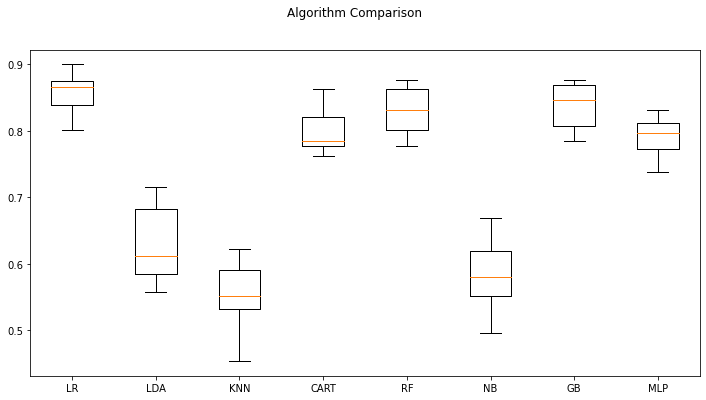

In [25]:
# boxplot algorithm comparison
d_boxplot = [results[i]['test_recall'] for i in np.arange(len(results))]
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(d_boxplot)
ax.set_xticklabels(names)
plt.show()

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Scaling</h2>

<a id='5.3.0'>
    <h2 style='font-size:150%;'>
        Comment on Standard Scaler</h2></a>

I have seen many kaggle submissions that default to `StandardScaler()` without the consideration of the data distribution. However, `StandardScaler()` assumes that **data is normally distributed** within each of the features and scales them such that the distribution is centered around $0$ with a standard deviation of $1$. If data is not normally distributed, `StandardScaler()` is not the best scaler to use. Therefore, we will not be using `StandardScaler()` before normalizing the data.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)</br>
[Selectively Scale Numerical Input Variables for Machine Learning, *Machine Learning Mastery*](https://machinelearningmastery.com/selectively-scale-numerical-input-variables-for-machine-learning/)

<a id='5.3.2'>
    <h2 style='font-size:150%;'>
        Robust Scaler</h2></a>

`RobustScaler()` is robust to outliers as it does not use the standard summary statistics such as the mean and standard deviation for scaling. Instead, `RobustScaler()` removes the median and scales the data using the **quantile range** (defaults to IQR). Although the scaler is less affected by the outliers, it does not remove the outliers.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)</br>
[Standardize or Normalize Examples in Python, *Medium*](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

In [26]:
scaler = RobustScaler()

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Validation Set</h2></a>

In [27]:
results_dic_scaler_robust = results_validation(models, scaler)

In [28]:
result_scaler_robust = results_summary_df(results_dic_scaler_robust)

In [29]:
result_scaler_robust

metric fit_time       score_time      test_accuracy      train_accuracy       \
           mean   std       mean  std          mean  std           mean  std   
mod                                                                            
LR         0.26  0.05       0.02 0.01          0.86 0.01           0.86 0.00   
LDA        0.12  0.02       0.01 0.00          0.91 0.01           0.91 0.00   
KNN        0.05  0.01       0.70 0.07          0.91 0.01           1.00 0.00   
CART       0.21  0.03       0.01 0.00          0.94 0.01           1.00 0.00   
RF         3.15  0.61       0.13 0.03          0.96 0.01           1.00 0.00   
NB         0.05  0.01       0.02 0.00          0.89 0.01           0.90 0.00   
GB         5.97  1.36       0.03 0.01          0.96 0.01           0.97 0.00   
MLP       87.72 23.42       0.03 0.01          0.95 0.01           1.00 0.00   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.54 0.02            0.54 0.00        0.86 0.03         0.86   
LDA              0.78 0.02            0.78 0.00        0.63 0.06         0.63   
KNN              0.74 0.02            1.00 0.00        0.66 0.06         1.00   
CART             0.80 0.03            1.00 0.00        0.80 0.04         1.00   
RF               0.92 0.02            1.00 0.00        0.83 0.04         1.00   
NB               0.71 0.05            0.71 0.01        0.58 0.05         0.59   
GB               0.93 0.02            0.95 0.00        0.84 0.04         0.89   
MLP              0.86 0.03            1.00 0.00        0.80 0.06         1.00   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.66 0.02     0.67 0.00         0.93 0.01          0.94 0.00  
LDA    0.01    0.69 0.04     0.70 0.01         0.93 0.01          0.93 0.00  
KNN    0.00    0.70 0.04     1.00 0.00         0.81 0.03          1.00 0.00  
CART   0.00    0.80 0.02     1.00 0.00         0.88 0.02          1.00 0.00  
RF     0.00    0.87 0.02     1.00 0.00         0.99 0.00          1.00 0.00  
NB     0.02    0.64 0.04     0.65 0.01         0.87 0.02          0.88 0.00  
GB     0.00    0.88 0.02     0.92 0.00         0.99 0.00          0.99 0.00  
MLP    0.00    0.83 0.03     1.00 0.00         0.98 0.00          1.00 0.00

In [30]:
df1 = result_scaler_robust.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [31]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [32]:
df2 = results_baseline.loc[:,['test_recall', 'train_recall']]
df2['scaler']=MinMaxScaler()

In [33]:
df2 = df2.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [34]:
df3 = pd.concat([df1, df2], axis=1)

In [35]:
df3

scaler RobustScaler()                        MinMaxScaler()                    \
metric    test_recall      train_recall         test_recall      train_recall   
                 mean  std         mean  std           mean  std         mean   
mod                                                                             
LR               0.86 0.03         0.86 0.00           0.86 0.03         0.86   
LDA              0.63 0.06         0.63 0.01           0.63 0.06         0.63   
KNN              0.66 0.06         1.00 0.00           0.56 0.05         1.00   
CART             0.80 0.04         1.00 0.00           0.80 0.04         1.00   
RF               0.83 0.04         1.00 0.00           0.83 0.04         1.00   
NB               0.58 0.05         0.59 0.02           0.58 0.05         0.59   
GB               0.84 0.04         0.89 0.00           0.84 0.04         0.89   
MLP              0.80 0.06         1.00 0.00           0.79 0.03         0.87   

scaler       
metric       
        std  
mod          
LR     0.00  
LDA    0.01  
KNN    0.00  
CART   0.00  
RF     0.00  
NB     0.02  
GB     0.00  
MLP    0.03

<a id='5.3.3'>
    <h2 style='font-size:150%;'>
        Quantile Transformer Scaler</h2></a>

`QuantileTransformer()` transforms the features to approximate a **uniform or a normal distribution** using **quantiles information**. Thus, the scaler spreads out the most frequent values as well as mitigate the effects of marginal outliers. This tranform is **non-linear**, so it may distort the features measured in the same scale but will help features measured in different scales more directly comparable. One can obtain a projection of the original values of a feature by using the cumulative distribution function. Another name for this scaler is the **Rank scaler**.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

In [36]:
scaler = QuantileTransformer()

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Validation Set</h2></a>

In [37]:
results_dic_scaler_quant_transf = results_validation(models, scaler)

In [38]:
result_scaler_quant_transf = results_summary_df(results_dic_scaler_quant_transf)

In [39]:
result_scaler_quant_transf

metric fit_time       score_time      test_accuracy      train_accuracy       \
           mean   std       mean  std          mean  std           mean  std   
mod                                                                            
LR         0.45  0.09       0.05 0.01          0.85 0.01           0.85 0.00   
LDA        0.26  0.03       0.04 0.01          0.91 0.01           0.91 0.00   
KNN        0.14  0.04       0.88 0.12          0.88 0.01           1.00 0.00   
CART       0.30  0.04       0.03 0.01          0.94 0.01           1.00 0.00   
RF         3.31  0.71       0.15 0.04          0.96 0.00           1.00 0.00   
NB         0.11  0.02       0.03 0.01          0.88 0.01           0.89 0.00   
GB         6.30  1.45       0.04 0.01          0.96 0.01           0.97 0.00   
MLP       65.92 11.19       0.06 0.02          0.95 0.01           0.98 0.01   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.52 0.02            0.53 0.00        0.86 0.03         0.86   
LDA              0.77 0.03            0.77 0.00        0.62 0.06         0.62   
KNN              0.65 0.05            1.00 0.00        0.59 0.05         1.00   
CART             0.80 0.03            1.00 0.00        0.80 0.04         1.00   
RF               0.92 0.02            1.00 0.00        0.83 0.03         1.00   
NB               0.65 0.05            0.66 0.01        0.59 0.07         0.60   
GB               0.93 0.02            0.95 0.00        0.84 0.04         0.89   
MLP              0.85 0.04            0.95 0.01        0.81 0.04         0.92   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.65 0.02     0.65 0.00         0.93 0.01          0.94 0.00  
LDA    0.01    0.68 0.04     0.69 0.00         0.93 0.01          0.93 0.00  
KNN    0.00    0.62 0.04     1.00 0.00         0.76 0.03          1.00 0.00  
CART   0.00    0.80 0.02     1.00 0.00         0.88 0.02          1.00 0.00  
RF     0.00    0.87 0.02     1.00 0.00         0.99 0.00          1.00 0.00  
NB     0.02    0.62 0.05     0.63 0.01         0.88 0.02          0.88 0.00  
GB     0.00    0.88 0.02     0.92 0.00         0.99 0.00          0.99 0.00  
MLP    0.02    0.83 0.03     0.94 0.01         0.98 0.01          1.00 0.00

In [40]:
df1 = result_scaler_quant_transf.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [41]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [42]:
df3 = pd.concat([df3, df1], axis=1)

In [43]:
df3

scaler RobustScaler()                        MinMaxScaler()                    \
metric    test_recall      train_recall         test_recall      train_recall   
                 mean  std         mean  std           mean  std         mean   
mod                                                                             
LR               0.86 0.03         0.86 0.00           0.86 0.03         0.86   
LDA              0.63 0.06         0.63 0.01           0.63 0.06         0.63   
KNN              0.66 0.06         1.00 0.00           0.56 0.05         1.00   
CART             0.80 0.04         1.00 0.00           0.80 0.04         1.00   
RF               0.83 0.04         1.00 0.00           0.83 0.04         1.00   
NB               0.58 0.05         0.59 0.02           0.58 0.05         0.59   
GB               0.84 0.04         0.89 0.00           0.84 0.04         0.89   
MLP              0.80 0.06         1.00 0.00           0.79 0.03         0.87   

scaler      QuantileTransformer()                         
metric                test_recall      train_recall       
        std                  mean  std         mean  std  
mod                                                       
LR     0.00                  0.86 0.03         0.86 0.00  
LDA    0.01                  0.62 0.06         0.62 0.01  
KNN    0.00                  0.59 0.05         1.00 0.00  
CART   0.00                  0.80 0.04         1.00 0.00  
RF     0.00                  0.83 0.03         1.00 0.00  
NB     0.02                  0.59 0.07         0.60 0.02  
GB     0.00                  0.84 0.04         0.89 0.00  
MLP    0.03                  0.81 0.04         0.92 0.02

<a id='5.3.4'>
    <h2 style='font-size:150%;'>
        Power Transformer Scaler</h2></a>

The `PowerTransformer()` is a family of **parametric, monotonic** transformations that are applied to **make data more Gaussian-like**. This is useful for modeling issues related to the variability of a variable that is unequal across the range **(heteroscedasticity)** or situations where **normality is desired**.

The power transform finds the optimal scaling factor in **stabilizing variance and minimizing skewness through maximum likelihood estimation**. Currently, Sklearn implementation of PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

In [44]:
scaler = PowerTransformer()

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Validation Set</h2></a>

In [45]:
results_dic_scaler_pwr_transf = results_validation(models, scaler)

In [46]:
result_scaler_pwr_transf = results_summary_df(results_dic_scaler_pwr_transf)

In [47]:
result_scaler_pwr_transf

metric fit_time       score_time      test_accuracy      train_accuracy       \
           mean   std       mean  std          mean  std           mean  std   
mod                                                                            
LR         1.21  0.09       0.04 0.01          0.85 0.01           0.86 0.00   
LDA        1.24  0.13       0.04 0.01          0.91 0.01           0.91 0.00   
KNN        1.52  0.13       1.07 0.19          0.89 0.01           1.00 0.00   
CART       0.99  0.12       0.03 0.01          0.93 0.01           1.00 0.00   
RF         3.93  0.83       0.15 0.04          0.95 0.01           1.00 0.00   
NB         0.74  0.13       0.03 0.01          0.89 0.01           0.89 0.00   
GB         6.09  1.32       0.04 0.01          0.95 0.01           0.96 0.00   
MLP       71.25 19.89       0.04 0.02          0.94 0.01           1.00 0.00   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.53 0.02            0.53 0.00        0.84 0.04         0.85   
LDA              0.76 0.04            0.77 0.00        0.61 0.05         0.62   
KNN              0.70 0.03            1.00 0.00        0.59 0.05         1.00   
CART             0.77 0.03            1.00 0.00        0.77 0.04         1.00   
RF               0.90 0.02            1.00 0.00        0.75 0.05         1.00   
NB               0.69 0.06            0.70 0.01        0.55 0.05         0.56   
GB               0.89 0.03            0.92 0.00        0.80 0.03         0.84   
MLP              0.83 0.04            1.00 0.00        0.79 0.03         1.00   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.65 0.02     0.65 0.00         0.93 0.01          0.93 0.00  
LDA    0.01    0.68 0.04     0.69 0.01         0.92 0.01          0.93 0.00  
KNN    0.00    0.64 0.04     1.00 0.00         0.77 0.03          1.00 0.00  
CART   0.00    0.77 0.03     1.00 0.00         0.86 0.02          1.00 0.00  
RF     0.00    0.82 0.03     1.00 0.00         0.98 0.01          1.00 0.00  
NB     0.02    0.61 0.04     0.62 0.01         0.89 0.01          0.89 0.00  
GB     0.00    0.84 0.02     0.88 0.00         0.98 0.00          0.99 0.00  
MLP    0.00    0.81 0.03     1.00 0.00         0.97 0.00          1.00 0.00

In [48]:
df1 = result_scaler_pwr_transf.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [49]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [50]:
df3 = pd.concat([df3, df1], axis=1)

In [51]:
df3

scaler RobustScaler()                        MinMaxScaler()                    \
metric    test_recall      train_recall         test_recall      train_recall   
                 mean  std         mean  std           mean  std         mean   
mod                                                                             
LR               0.86 0.03         0.86 0.00           0.86 0.03         0.86   
LDA              0.63 0.06         0.63 0.01           0.63 0.06         0.63   
KNN              0.66 0.06         1.00 0.00           0.56 0.05         1.00   
CART             0.80 0.04         1.00 0.00           0.80 0.04         1.00   
RF               0.83 0.04         1.00 0.00           0.83 0.04         1.00   
NB               0.58 0.05         0.59 0.02           0.58 0.05         0.59   
GB               0.84 0.04         0.89 0.00           0.84 0.04         0.89   
MLP              0.80 0.06         1.00 0.00           0.79 0.03         0.87   

scaler      QuantileTransformer()                        PowerTransformer()  \
metric                test_recall      train_recall             test_recall   
        std                  mean  std         mean  std               mean   
mod                                                                           
LR     0.00                  0.86 0.03         0.86 0.00               0.84   
LDA    0.01                  0.62 0.06         0.62 0.01               0.61   
KNN    0.00                  0.59 0.05         1.00 0.00               0.59   
CART   0.00                  0.80 0.04         1.00 0.00               0.77   
RF     0.00                  0.83 0.03         1.00 0.00               0.75   
NB     0.02                  0.59 0.07         0.60 0.02               0.55   
GB     0.00                  0.84 0.04         0.89 0.00               0.80   
MLP    0.03                  0.81 0.04         0.92 0.02               0.79   

scaler                         
metric      train_recall       
        std         mean  std  
mod                            
LR     0.04         0.85 0.00  
LDA    0.05         0.62 0.01  
KNN    0.05         1.00 0.00  
CART   0.04         1.00 0.00  
RF     0.05         1.00 0.00  
NB     0.05         0.56 0.02  
GB     0.03         0.84 0.00  
MLP    0.03         1.00 0.00

Going with Quantile Transformer.

# PR-AUC & Recall

> However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

— The Relationship Between Precision-Recall and ROC Curves, 2006.

In [52]:
# split into train & test set
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Plot</h2></a>

LR:   Precision: 53.90%  Recall: 89.23%  F-2: 67.21%  Support: 325
LDA:   Precision: 79.17%  Recall: 64.31%  F-2: 70.97%  Support: 325
KNN:   Precision: 64.51%  Recall: 58.15%  F-2: 61.17%  Support: 325
CART:   Precision: 77.65%  Recall: 83.38%  F-2: 80.42%  Support: 325
RF:   Precision: 93.49%  Recall: 88.31%  F-2: 90.82%  Support: 325
NB:   Precision: 63.73%  Recall: 55.69%  F-2: 59.44%  Support: 325
GB:   Precision: 92.97%  Recall: 89.54%  F-2: 91.22%  Support: 325
MLP:   Precision: 87.30%  Recall: 84.62%  F-2: 85.94%  Support: 325


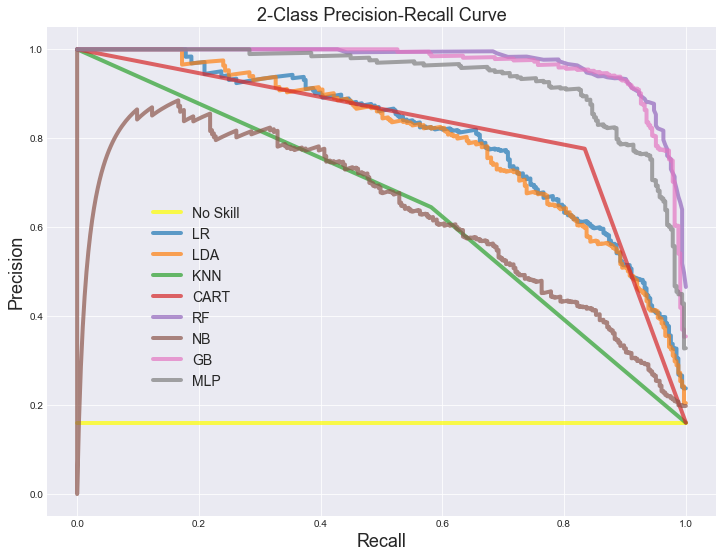

In [53]:
# plot the precision-recall curves
plt.figure(figsize=(12,9))
plt.style.use('seaborn-darkgrid')

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], label='No Skill', 
         marker='', linewidth=4, alpha=0.7, color='yellow')
scaler = QuantileTransformer()

# fit a model
for i in np.arange(len(models)):
    model = models[i][1]
    pipeline = Pipeline([('s', scaler),('m',model)])
    pipeline.fit(x_train, y_train)
    
    # predict using test set
    y_hat = pipeline.predict(x_test) # predict class values
    y_hat_prob = pipeline.predict_proba(x_test)[:, 1] # predict probabilities; index added to retrieve just the probabilities for the positive class
    
    # print out the metrics for each model
    precision, recall, f2, support = precision_recall_fscore_support(y_test, y_hat)
    print('%s:   Precision: %.2f%%  Recall: %.2f%%  F-2: %.2f%%  Support: %.0f' % (
    models[i][0], precision[1]*100, recall[1]*100, f2[1]*100, support[1]))

    # compute precision-recall pairs for different probability thresholds & plot the results
    precision_t, recall_t, _ = precision_recall_curve(y_test, y_hat_prob)
    plt.plot(recall_t, precision_t, label=models[i][0],
            marker='', linewidth=4, alpha=0.7)
        
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

# show the legend
plt.legend(loc = (0.15,0.25), fontsize=14)
plt.title('2-Class Precision-Recall Curve',
         fontsize=18, fontweight=2)

# show the plot
plt.show()

In [54]:
finish_normal = time.perf_counter()

In [55]:
print(f'Finished in {round(finish_normal-start_normal, 2)} second(s) or {round((finish_normal-start_normal)/60, 2)} minute(s).')

Finished in 673.31 second(s) or 11.22 minute(s).


Some promising candidates are: RF, GB, and MLP with the current pipelline. This ranking may change with the addition of feature selection / extraction and possibly another outlier treatment.